# AdaBoost(Adaptive Boosting)
>同质个体学习器按照个体学习器之间是否存在依赖关系可以分为两类，第一个是个体学习器之间存在强依赖关系，一系列个体学习器基本都需要串行生成，代表算法是boosting系列算法，第二个是个体学习器之间不存在强依赖关系，一系列个体学习器可以并行生成，代表算法是bagging和随机森林（Random Forest）系列算法。

Adaboost算法的实现步骤如下：

1. 初始化样本权重，每个样本的权重为 $w_i = 1/N$，其中 $N$ 为样本总数。

2. 迭代进行以下操作：

   a. 在当前样本权重下训练一个弱分类器 $h_t(x)$。
   
   b. 计算分类器的误差率 $\epsilon_t = \frac{\sum_{i=1}^N w_i I(y_i \neq h_t(x_i))}{\sum_{i=1}^N w_i}$，其中 $I$ 为指示函数，$y_i$ 为第 $i$ 个样本的标签，$x_i$ 为第 $i$ 个样本的特征向量。
   
   c. 计算分类器的权重 $\alpha_t = \frac{1}{2} \ln{\frac{1-\epsilon_t}{\epsilon_t}}$。
   
   d. 更新样本权重 $w_i \leftarrow w_i e^{-\alpha_t y_i h_t(x_i)}$，其中 $y_i \in \{-1, 1\}$ 表示第 $i$ 个样本的真实标签。
   
   e. 对更新后的样本权重进行归一化，即 $w_i \leftarrow \frac{w_i}{\sum_{j=1}^N w_j}$。
   
3. 最终输出分类器 $H(x) = sign(\sum_{t=1}^T \alpha_t h_t(x))$，其中 $T$ 为迭代次数。

这里的 $sign$ 函数表示符号函数，即 $sign(y) = \begin{cases} 1, & y > 0 \\ -1, & y \leq 0 \end{cases}$。

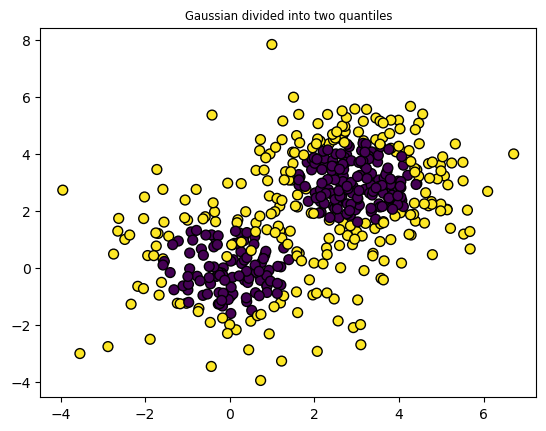

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.datasets import make_gaussian_quantiles
from sklearn.datasets import make_classification

plt.title("Gaussian divided into two quantiles", fontsize="small")
# X, Y = make_gaussian_quantiles(n_samples=120, n_features=2, n_classes=2, shuffle=True, random_state=3)
# X, Y = make_classification(n_samples = 50, n_features =2 ,n_redundant = 0, random_state = 6)
# 符合高斯分布，均值默认为0，方差为2，200个样本，2个特征，标签有2类，打乱
x1,y1 = make_gaussian_quantiles(
    cov=2,
    n_samples=200,
    n_features=2,
    n_classes=2,
    shuffle=True,
    random_state=1
)
# 满足高斯分布，两个特征，均值都为3，方差为1.5,300个样本数据，标签也有两个类别，打乱
x2,y2 = make_gaussian_quantiles(
    mean=(3,3),
    cov=1.5,
    n_samples=300,
    n_features=2,
    n_classes=2,
    shuffle=True,
    random_state=1
)
# 水平拼接：x1, x2
X = np.vstack((x1,x2))
# 垂直拼接：标签值 
Y = np.hstack((y1,y2))
plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=50, edgecolor="k")
plt.show()

In [75]:
class AdaBoost():
    def __init__(self, n_estimators, learning_rate, X, Y):
        self.T = n_estimators
        self.X = X
        self.Y = Y
        self.lr = learning_rate
        self.alphas = []
        self.m, self.d = X.shape  # 样本个数和样本维数
        self.weights = np.array([1/self.m for _ in range(self.m)])
        self.betas = []
        self.max_iter = 10
        self.train_weak_classifier()
        
    def logistic(self, betas, x):
        input = -betas.T @ x
        if input > 0:  # 对sigmoid函数优化,避免出现极大的数据栈溢出
            return np.exp(-input[0]) / (1 + np.exp(-input[0]))
        else:
            return 1 / (1 + np.exp(input))
        
    
    def train_weak_classifier(self):
        for k in range(self.T):
            """采用对数几率回归作为弱分类器"""
            train_X = np.concatenate((self.X, np.ones((self.m, 1))), axis=1)
            betas = np.random.random((self.d + 1, 1)) - 0.5
            dbetas = 0
            for _ in range(self.max_iter):
                rindex = np.arange(self.m)
                np.random.shuffle(rindex)
                """SGD,每次随机训练一个样本"""
                """针对式 (3.27) 只需要给第 i 项乘以 mDt(xi)即可, 相当于每次随机梯度下降选择样本时以概率
                Dt(xi)选择样本 xi 即可."""
                for i in rindex:
                    xi = train_X[i,:][:, np.newaxis]
                    dbetas += -self.m * self.weights[i] * xi * (self.Y[i] - self.logistic(betas, xi)[0])
                    
                betas -= self.lr * dbetas
                
            # 更新错误率
            error = 1e-5
            error_num = 0
            for i in range(self.m):
                xi = train_X[i,:][:, np.newaxis]
                if (self.logistic(betas, xi) > 0.5 and self.Y[i] == 1) or (self.logistic(betas, xi) < 0.5 and self.Y[i] == 0):
                    pass
                else:
                    error_num += 1
                    error += self.weights[i]
            
            if error > 0.5:
                """误差为 0.5, 即相当于随机猜测 (最糟糕的二分类器是分类误差为 0.5, 当二分类器分类误差为 1 时相当于
                分类误差为 0 , 因为将预测结果反过来用就是了)"""
                error = 1 - error
                betas = -betas  # 取反, 相当于取另一个半空间
                
            self.betas.append(betas)
            alpha = 0.5 * np.log((1 - error) / error)
            self.alphas.append(alpha)

            # 更新样本权重
            for i in range(self.m):
                xi = train_X[i,:][:, np.newaxis]
                if (self.logistic(betas, xi) > 0.5 and self.Y[i] == 1) or (self.logistic(betas, xi) < 0.5 and self.Y[i] == 0):
                    self.weights[i] = self.weights[i] * np.exp(-alpha)
                else:
                    self.weights[i] = self.weights[i] * np.exp(alpha)

            self.weights = self.weights / np.sum(self.weights)  # 归一化
            
            percentage = round(k / self.T * 100)
            print("\r进度: {}%: ".format(percentage), "▓" * (percentage // 2), end="")

        
        print("Done.")
    
    def predict(self, x):
        psum = 0
        for i in range(self.T):
            if self.logistic(self.betas[i], x) > 0.5:
                psum += self.alphas[i]
            else:
                psum -= self.alphas[i]
                
        if psum > 0:
            return 1
        else:
            return -1
        
        #return psum

strong_classifier = AdaBoost(1500, 0.001, X, Y)  # 学习率很关键，根据数据原始尺寸修改，或归一化

进度: 100%:  ▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓▓Done.


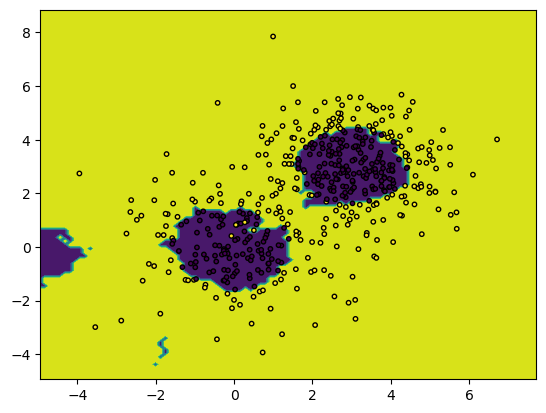

In [114]:
x1_min = X[:,0].min()-1
x1_max = X[:,0].max()+1
x2_min = X[:,1].min()-1
x2_max = X[:,1].max()+1
# 生成x,y的数据
n = 100
plot_x = np.linspace(x1_min, x1_max, n)
plot_y = np.linspace(x2_min, x2_max, n)
plot_X, plot_Y = np.meshgrid(plot_x, plot_y)
plot_Z = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        x = np.array([plot_x[i],plot_y[j],1])[:, np.newaxis]
        plot_Z[j, i] = strong_classifier.predict(x) 

plt.contourf(plot_X, plot_Y, plot_Z)
plt.scatter(X[:, 0], X[:, 1], marker="o", c=Y, s=10, edgecolor="k")
#for i in range(a.T):
#    b = a.betas[i]
#    plt.plot([x1_min,x1_max],[(-b[2]-b[0]*x1_min)/b[1],(-b[2]-b[0]*x1_max)/b[1]])
plt.axis([x1_min, x1_max, x2_min, x2_max])
plt.show()